# Notes

First iteration is to model: goal to have end to end pipeline from data to dynamics for a patient
- Don't have test train split
- Predict on training data
- Entry is an exercise
- Include exercise meta like https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ 

In [1]:
import os 
import re
import csv
import json
from datetime import datetime

import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import classification_report

# Constants

In [2]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [3]:
dir_data_root = os.path.join('..', 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'exercises_raw')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'exercises_augmented')
dir_patiens_sessions = os.path.join(dir_data_root, 'json', 'patients_sessions')

# Data prep

### Build training set

In [4]:
def exercise_to_input(file_path):
    with open(file_path, 'r') as f_r:
        exercise = json.load(f_r)
        
        exercise_sequence = []

        for poi in sorted(exercise['pois'].keys()):
            sequences = exercise['pois'][poi]
            exercise_sequence.append(sequences['xs'])
            exercise_sequence.append(sequences['ys'])
            exercise_sequence.append(sequences['zs'])
    
        exercise_sequence = pad_sequences(
            exercise_sequence,
            padding="pre",
            maxlen=SEQ_MAX_LEN)
    
    x_a_1 = [0] * NUM_EXERCISES
    x_a_2 = [0] * NUM_FLAG_BS
    x_a_1[exercise['meta']['id']] = 1
    x_a_2[exercise['meta']['flag_before_surgery']] = 1

    return x_a_1 + x_a_2, exercise_sequence, exercise['meta']['evaluation']

In [5]:
xslist_a = list()
xslist_b = list()
yslist = list()

exercises_sources = [
    dir_exercises,
    dir_exercises_augmented
]

for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue

        xs_a, xs_b, ys = exercise_to_input(file_path)

        yslist.append(ys)
        xslist_a.append(xs_a)  
        xslist_b.append(xs_b)

        #break
            
ys = np.array(yslist)
xs_a = np.array(xslist_a)   
xs_b = np.array(xslist_b) 


print(ys.shape)
print(xs_a.shape)
print(xs_b.shape)

(8592,)
(8592, 11)
(8592, 63, 600)


## Modeling

In [6]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [7]:
def get_model():
    chanDim = -1

    inputA = Input(shape=xs_a.shape[1:])
    inputB = Input(shape=xs_b.shape[1:])

    x_a = Dense(4, activation="relu")(inputA)
    x_a = Model(inputs=inputA, outputs=x_a)

    #x_b = LSTM(64)(inputB)
    x_b = Conv1D(16, 3, padding='same', activation='relu')(inputB)
    x_b = BatchNormalization(axis=chanDim)(x_b)
    x_b = MaxPooling1D((2))(x_b)
    x_b = Conv1D(32, 3, padding='same', activation='relu')(x_b)
    x_b = BatchNormalization(axis=chanDim)(x_b)
    x_b = MaxPooling1D((2))(x_b)
    x_b = Conv1D(64, 3, padding='same', activation='relu')(x_b)
    x_b = BatchNormalization(axis=chanDim)(x_b)
    x_b = MaxPooling1D((2))(x_b)
    x_b = Conv1D(64, 3, padding='same', activation='relu')(x_b)
    x_b = BatchNormalization(axis=chanDim)(x_b)
    x_b = MaxPooling1D((2))(x_b)
    x_b = Flatten()(x_b)
    x_b = Dropout(0.5)(x_b)
    x_b = Dense(128, activation="relu")(x_b)
    x_b = Model(inputs=inputB, outputs=x_b)

    combined = concatenate([x_a.output, x_b.output])
    x = Dense(32, activation="relu")(combined)
    x = Dense(6, activation="softmax")(x)
    model = Model(inputs=[x_a.input, x_b.input], outputs=x)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200),
        metrics=['accuracy']
    )
    
    return model

In [8]:
test_model = get_model()
test_model.summary()

Metal device set to: Apple M1


2023-06-08 12:11:54.906674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-08 12:11:54.906791: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 63, 600)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 63, 16)       28816       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 16)      64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 31, 16)       0           ['batch_normalization[0][0]

In [9]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


In [10]:
weight_training_classes = {0: 0.32075471698113206, 
                           1: 1.1333333333333333,
                           2: 1.3076923076923077, 
                           3: 3.4, 
                           4: 3.4,
                           5: 1.5454545454545454}

### K-fold evaluation

In [11]:
k = 5
train = 0.8
val = 0.2
test = 0.2

In [12]:
VERBOSE = 0
EPOCHS = 100
BATCH_SIZE = 8

In [13]:
from sklearn.model_selection import KFold

In [14]:
def get_k_indx(k, n):

    k_fold = KFold(n_splits=k)
    train_ = []
    val_ = []
    test_ = []
    indx = []

    for train_indices, test_indices in k_fold.split(ys):
        n_k = len(train_indices)
        val_split = int(n_k * train)
        indx.append([train_indices[:val_split],train_indices[val_split + 1:], test_indices])
    
    return indx

In [15]:
indxs = get_k_indx(k, len(ys))

for i in range(k):
    train_indx, val_indx, test_indx  = indxs[i]
    xs_a_i = xs_a[train_indx]
    xs_a_i_val = xs_a[val_indx]
    xs_a_i_test = xs_a[test_indx]
    
    xs_b_i = xs_b[train_indx]
    xs_b_i_val = xs_b[val_indx]
    xs_b_i_test = xs_b[test_indx]
    
    ys_i = ys[train_indx]
    ys_i_val = ys[val_indx]
    ys_i_test = ys[test_indx]

    model = get_model()

    model.fit(
        x=[xs_a_i, xs_b_i], y=ys_i, 
        validation_data=([xs_a_i_val, xs_b_i_val], ys_i_val),
        batch_size=BATCH_SIZE, epochs=EPOCHS,
        class_weight=weight_training_classes,
        verbose=VERBOSE)
    
    
    
    y_pred = model.predict([xs_a_i_test, xs_b_i_test],verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)

    print(classification_report(ys_i_test, y_pred_bool))

2023-06-08 12:11:55.887720: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-08 12:11:56.602730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 12:12:09.274710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 12:31:24.023871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.99      0.92      0.95       773
           1       0.93      0.96      0.94       272
           2       0.88      0.99      0.93       283
           3       0.97      0.98      0.97        97
           4       0.95      0.96      0.96       104
           5       0.94      0.96      0.95       190

    accuracy                           0.95      1719
   macro avg       0.94      0.96      0.95      1719
weighted avg       0.95      0.95      0.95      1719



2023-06-08 12:31:26.314112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 12:31:38.508588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 12:51:12.365696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.96      0.84      0.90       781
           1       0.78      0.92      0.84       283
           2       0.80      0.91      0.85       267
           3       0.89      0.89      0.89       112
           4       0.86      0.93      0.89       105
           5       0.88      0.92      0.90       171

    accuracy                           0.88      1719
   macro avg       0.86      0.90      0.88      1719
weighted avg       0.89      0.88      0.88      1719



2023-06-08 12:51:14.394893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 12:51:27.848982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 13:11:06.496777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.98      0.93      0.96       760
           1       0.93      0.97      0.95       269
           2       0.97      0.97      0.97       301
           3       0.97      0.99      0.98        87
           4       0.91      0.99      0.95        87
           5       0.92      0.98      0.95       214

    accuracy                           0.96      1718
   macro avg       0.95      0.97      0.96      1718
weighted avg       0.96      0.96      0.96      1718



2023-06-08 13:11:08.459396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 13:11:21.026488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 13:30:34.258275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.99      0.95      0.97       767
           1       0.93      0.99      0.96       293
           2       0.94      0.98      0.96       280
           3       0.98      0.98      0.98        99
           4       0.92      0.96      0.94       101
           5       0.97      0.99      0.98       178

    accuracy                           0.97      1718
   macro avg       0.96      0.97      0.96      1718
weighted avg       0.97      0.97      0.97      1718



2023-06-08 13:30:37.108737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 13:30:50.207528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 13:50:48.641817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.98      0.90      0.94       775
           1       0.88      0.96      0.92       271
           2       0.89      0.95      0.92       277
           3       0.89      0.96      0.92       101
           4       0.93      0.96      0.94       107
           5       0.89      0.95      0.92       187

    accuracy                           0.93      1718
   macro avg       0.91      0.95      0.93      1718
weighted avg       0.93      0.93      0.93      1718



In [27]:
import statistics

print(statistics.mean([0.88, 0.91, 0.69, 0.90, 0.88]))
print(statistics.mean([0.95, 0.88, 0.96, 0.96, 0.93]))

0.852
0.9359999999999999


# Patient dynamics

In [17]:
from operator import attrgetter

In [18]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [19]:
weights = [1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
exercises_number = 9

## Single patient with details

In [20]:
patient_id = '00000000020'

In [21]:
sessions = []
with open(os.path.join(dir_patiens_sessions, '%s.json' % patient_id), 'r') as f_r:
    sessions = json.load(f_r)
    
print(sessions)

[{'id': 0, 'exercise_dates': '2019-06-03', 'evaluation': 0, 'flag_before_surgery': 1, 'number_of_exercises': 9}, {'id': 1, 'exercise_dates': '2019-08-29', 'evaluation': 1, 'flag_before_surgery': 1, 'number_of_exercises': 9}, {'id': 2, 'exercise_dates': '2019-12-30', 'evaluation': 0, 'flag_before_surgery': 1, 'number_of_exercises': 9}]


In [22]:
sessions.sort(key=lambda x: x['exercise_dates'])
print(sessions)

[{'id': 0, 'exercise_dates': '2019-06-03', 'evaluation': 0, 'flag_before_surgery': 1, 'number_of_exercises': 9}, {'id': 1, 'exercise_dates': '2019-08-29', 'evaluation': 1, 'flag_before_surgery': 1, 'number_of_exercises': 9}, {'id': 2, 'exercise_dates': '2019-12-30', 'evaluation': 0, 'flag_before_surgery': 1, 'number_of_exercises': 9}]


1


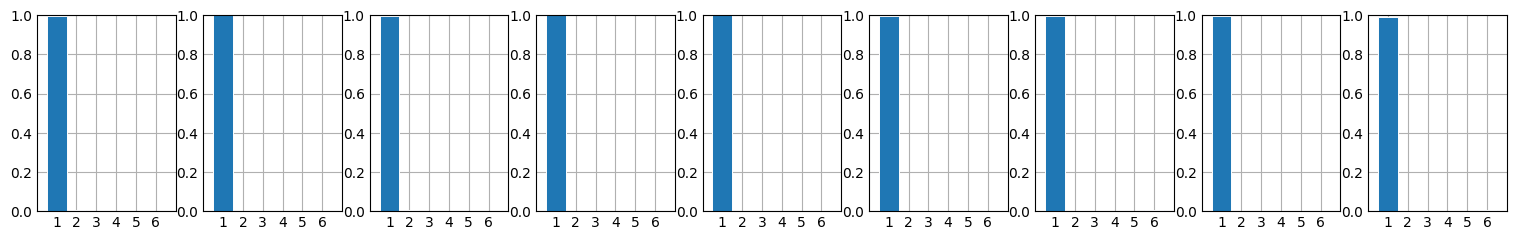

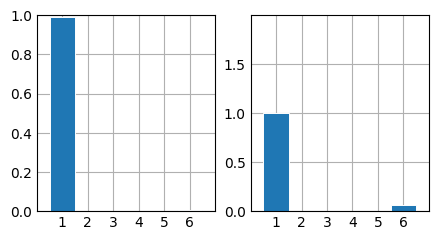

2


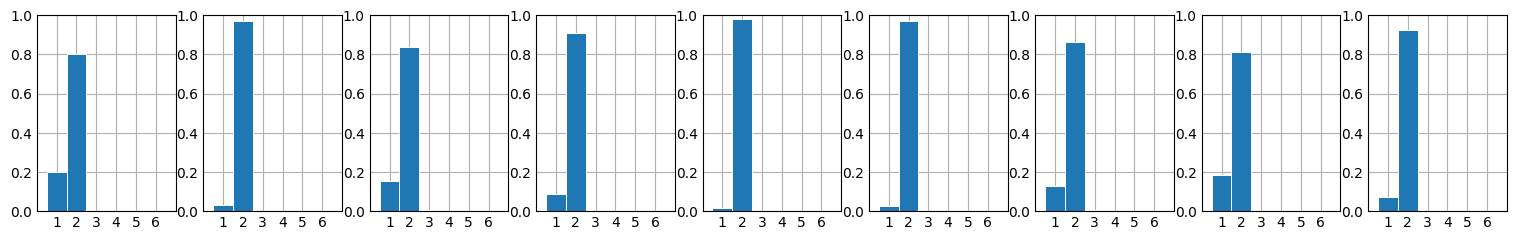

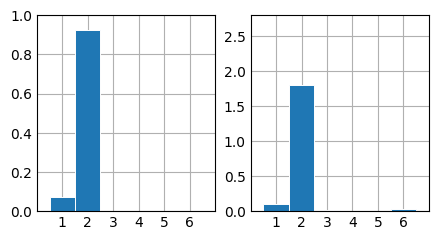

1


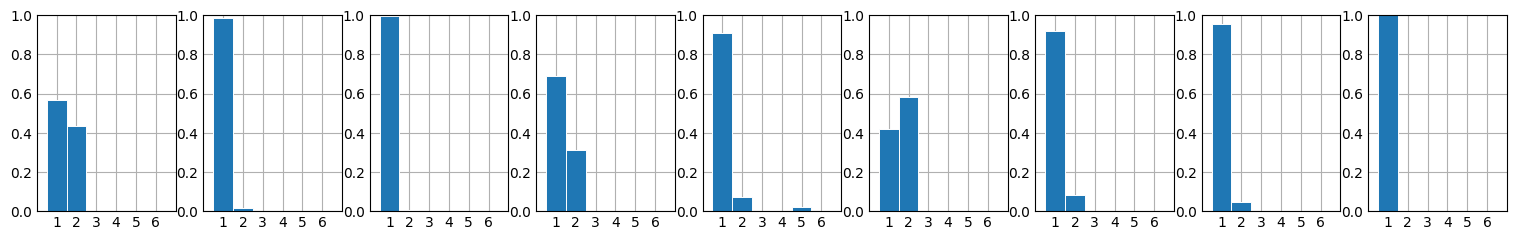

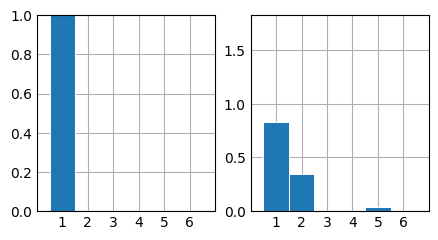

[1.0574393893825231, 1.9297509394704466, 1.2075582549074584]


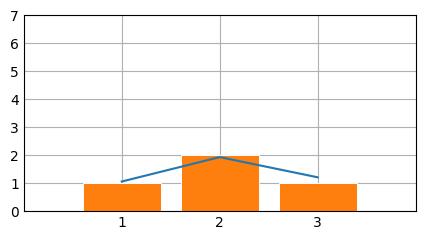

In [23]:
dynamic = []
evaluations = []

for session in sessions:
    exercises_result = []
    print(session['evaluation'] + 1) #from index to class
    evaluations.append(session['evaluation'] + 1)

    fig, axs = plt.subplots(1,9,figsize=(15,2)) 

    for exercise_id in range(exercises_number):
        file_name = os.path.join(
            dir_exercises, '%s_%s_%s.json' % (
                patient_id, 
                session['id'],
                exercise_id))
        
        if not os.path.isfile(file_name):
            continue
            
        xs_a, xs_b, ys = exercise_to_input(file_name)
        
        xs_a = np.array([xs_a])   
        xs_b = np.array([xs_b]) 
        
        #print(xs_a.shape)
        #print(xs_b.shape)
        
        
        y_pred = model.predict([xs_a, xs_b], verbose=0)
        exercises_result.append(list(y_pred[0]))
        
                
        axs[exercise_id].bar(1 + np.arange(6), y_pred[0], width=1, edgecolor="white", linewidth=0.7)

        axs[exercise_id].set(
            xlim=(0, 7), 
            xticks=np.arange(1, 7),
            ylim=(0, 1))
    
    #average session 
    prediction = np.average(np.array(exercises_result), axis=0)
    exercise_score = [y*w for y, w in zip(prediction,weights)]
    dynamic.append(sum(exercise_score))
    
    fig, axs = plt.subplots(1,2,figsize=(4,2)) 
        
    x = 1 + np.arange(6)
    y_pred = y_pred[0]
    y_score = exercise_score

    axs[0].bar(x, y_pred, width=1, edgecolor="white", linewidth=0.7)

    axs[0].set(xlim=(0, 7), 
              xticks=np.arange(1, 7),
              ylim=(0, 1), 
             )


    axs[1].bar(x, y_score, width=1, edgecolor="white", linewidth=0.7)
    axs[1].set(xlim=(0, 7), 
              xticks=np.arange(1, 7),
              ylim=(0, max(y_score) + 1), 
             )

    plt.show()    
        

print(dynamic)
fig, ax = plt.subplots(figsize=(4,2)) 

x = 1 + np.arange(len(sessions))
y = dynamic

#ax.bar(x, y, width=1, edgecolor="white", linewidth=0.7)
ax.plot(x, y, color='tab:blue')
ax.bar(x, evaluations, color='tab:orange', edgecolor="white", linewidth=0.7)

ax.set(xlim=(0, len(sessions) + 1), 
          xticks=np.arange(1, len(sessions) + 1),
          ylim=(0, max(7, max(y) + 1)), 
         )

plt.show() 

## Patients Dynamics: Multiple Patients

In [24]:
def get_fine_score(patient_id):
    sessions = []
    fine_score = []
    evaluations = []

    with open(os.path.join(dir_patiens_sessions, '%s.json' % patient_id), 'r') as f_r:
        sessions = json.load(f_r)
        
    sessions.sort(key=lambda x: x['exercise_dates'])
    
    for session in sessions:
        exercises_result = []
        evaluations.append(session['evaluation'] + 1)
    
        for exercise_id in range(exercises_number):
            file_name = os.path.join(
                dir_exercises, '%s_%s_%s.json' % (
                    patient_id, 
                    session['id'],
                    exercise_id))

            if not os.path.isfile(file_name):
                continue

            xs_a, xs_b, ys = exercise_to_input(file_name)

            xs_a = np.array([xs_a])   
            xs_b = np.array([xs_b]) 

            y_pred = model.predict([xs_a, xs_b], verbose=0)
            exercises_result.append(list(y_pred[0]))

        #average session 
        prediction = np.average(np.array(exercises_result), axis=0)
        exercise_score = [y*w for y, w in zip(prediction,weights)]
        fine_score.append(sum(exercise_score))
        
    return fine_score, evaluations

In [25]:
patients = [
    '00000000034',
    '00000000074',
    '00000000058',
    '00000000039',
    '00000000081',
    '00000000042',
]

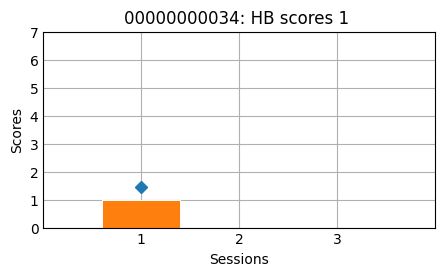

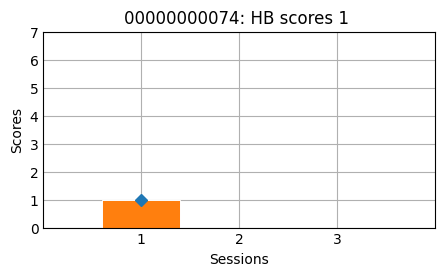

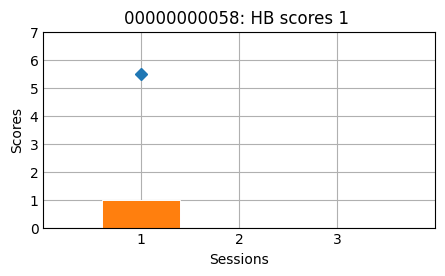

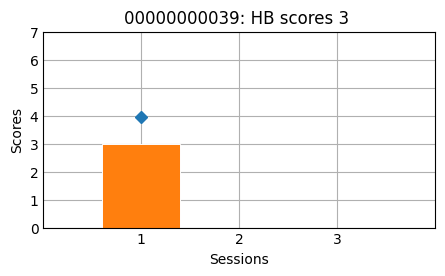

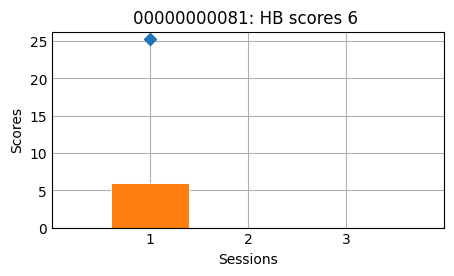

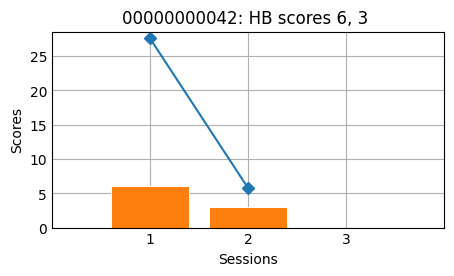

In [26]:
for patient_id in patients:
    fine_score, evaluations = get_fine_score(patient_id)
    fig, ax = plt.subplots(figsize=(4,2)) 

    x = 1 + np.arange(len(evaluations))

    ax.plot(x, fine_score, color='tab:blue', marker='D')
    ax.bar(x, evaluations, color='tab:orange', edgecolor='white', linewidth=0.7)

    ax.set(
        xlim=(0, len(sessions) + 1), 
        xticks=np.arange(1, len(sessions) + 1),
        ylim=(0, max(7, max(fine_score) + 1)),
        xlabel='Sessions',
        ylabel='Scores',
        title='%s: HB scores %s ' % (patient_id, ', '.join(map(str, evaluations)))
    )

plt.show() 

__END__